In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt


In [2]:
device=torch.device('cuda' if torch.cuda.is_available else 'cpu')



In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.ion()

In [4]:
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets,transforms,utils
from sklearn.model_selection import train_test_split
import os
from skimage import io
from skimage import transform as trans

In [5]:
data_dir="train/"
mask_dir="train_masks/"
all_images=os.listdir(data_dir) #gets a list of names of the contents of the folder
    

In [6]:
train_image,eval_image=train_test_split(all_images,train_size=0.8,test_size=0.2)

In [7]:
output_size=512 #rescaling the images to 512x512

In [8]:
class CarvanaDataset(Dataset):
    
    def __init__(self,data_dir,mask_dir,train_image,eval_image,Train=True,transforms=None):
        
        self.data_dir=data_dir
        self.mask_dir=mask_dir
        self.transforms=transforms
        self.train_image=train_image
        self.eval_image=eval_image
        self.Train=Train
        
    def __len__(self):
        if self.Train==True:
            return len(train_image)
        else:
            return len(eval_image)
        
    def __getitem__(self,idx):
        if self.Train==True:
            im=io.imread(os.path.join(self.data_dir,self.train_image[idx]))
            im_mask=io.imread(os.path.join(self.mask_dir,self.train_image[idx].split(".")[0]
                                         + '_mask.gif'))
            sample={'image':im,'mask':im_mask}
        else:
            im=io.imread(os.path.join(self.data_dir,eval_image[idx]))
            im_mask=io.imread(os.path.join(self.mask_dir,self.eval_image[idx].split(".")[0]+'_mask.gif'))
            sample={'image':im,'mask':im_mask}
                             
        if self.transforms:
            sample=self.transforms(sample)
                
        return sample          

In [9]:
#trial_set=CarvanaDataset(data_dir,mask_dir,train_image,eval_image,Train=True,transforms=None)
#sample=trial_set[0]
#im=sample['image']
#mas=sample['mask']
#res=cv2.bitwise_and(im,im,mask=mas)
#im.shape

In [10]:
class resize(object):
    def __init__(self,output_size):
        self.output_size=output_size
        
    def __call__(self,sample):
        im,mask=sample['image'],sample['mask']
        new_h,new_w=self.output_size,self.output_size
        
        img=trans.resize(im,(new_h,new_w))
        mask_img=trans.resize(mask,(new_h,new_w))
        return {'image':img,'mask':mask_img}

class ToTensor(object):
    def __call__(self,sample):
        image,mask=sample['image'],sample['mask']
        image=image.transpose(2,0,1)
        return {'image':torch.from_numpy(image).double(),'mask':torch.from_numpy(mask).double()}
        
        

In [11]:
tsfm=transforms.Compose([resize(512),ToTensor()]) #composed transform to be applied
train_set=CarvanaDataset(data_dir,mask_dir,train_image,eval_image,Train=True,transforms=tsfm)
eval_set=CarvanaDataset(data_dir,mask_dir,train_image,eval_image,Train=False,transforms=tsfm)

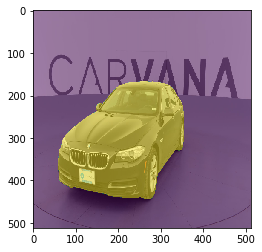

In [12]:
#displaying sample images
import cv2
sample=train_set[0]
img=sample['image'].numpy().transpose(1,2,0)
msk=sample['mask'].numpy()
plt.imshow(img)
plt.imshow(msk,alpha=0.5) #image with mask

In [13]:
train_loader=DataLoader(train_set,batch_size=1,shuffle=True)
eval_loader=DataLoader(eval_set,batch_size=1,shuffle=True)

In [14]:
from UNet import Unet

In [15]:
model=Unet(3,depth=5,merge_mode='concat')
optimizer=optim.SGD(model.parameters(),momentum=0.99,lr=0.01)
criterion=nn.BCELoss()

In [ ]:
for epoch in range(1):
    running_loss=0.0
    for i,data in enumerate(train_loader):
        image=data['image'].float()
        mask=data['mask'].float()
        optimizer.zero_grad()
        output=model(image)
        loss=criterion(output,mask)
        loss.backward()
        optimizer.step()
        print ('image {}'.format(i))
        running_loss+=loss
        if i%100==1:
            print ("Loss={}".format(running_loss))